1. [Setup data set](#qH6NSvLcvWq0dIOGUFm7hjIWOO9EcDo4yg)
2. [Define Mine model](#LWu8a55iXd1rXiOxqHLRRPEri06W2uHUSaopejkOyLc)
3. First architecture
    1. [Compute MI of fine-grained model with Net 1](#ITDw/rAcOpXEcj2/jr66qiHnAVLmZUerYxogQhfGZKU)
        1. [Compute MI of fine-grained model with Net 1 (learning rate experiment)](#rsXTn4Xt28E5GogIizo92r/Pd6a2FFGwwk7KSKGENeY)
    2. [Compute MI of frozen convolution with Net 1](#XwBXAc9EQHz4UXGAypEpu8Nx1VSK7MgK6aV54)
4. [Alternative architecture](#bmPi9gykQdCvsmB9Ey9o3N0Z2tpRuAEEgPXrIqeLp5M8)
    1. [Compute MI of fine-grained 3x3 model with Net 2](#XMXqmJFyTasMbsY1APB9UEA)
        1. [Compute MI of fine-grained 3x3 model with Net 2 (learning rate scheduler experiment)](#ks6iDaSVrGnNdtAaveXITBiwGVqpS4aom7JFAik9UsY)
    2. [Compute MI of frozen 3x3 convolution with Net 2](#StnSWBsZkvH19fVkpidI)
        1. [Compute MI of frozen 3x3 convolution with Net 2 (learning rate scheduler experiment)](#75w0xiOCI1V0afZ12xKy4NqY)
        2. [Compute MI of frozen 3x3 convolution with Net 2 (learning rate)](#yjaFT5zBKGsxifupr2J1qLx8w)
    3. [Mine on the fine-grained data (on the 2x2 model)](#zu750PMa3YAxhw2z49AvlNJP1DE)
    4. [Mine on the coarse-grained frozen convolution (on the 2x2 model)](#FxFiXG4HyPIyOgPFs3aNTLDoI)
    5. [Jointly optimize the coarse-grained convolution (on the 2x2 model) and MI of coarse-grained convolution](#gS7O2ggXcb34OJzzvfm2crOhmEGCROW)
5. [Analytic MI frozen convolution](#IMXNuzYpbqF3yE71tcGPkyCUgonu44gg0wtJKI)
    1. [Analytic fine-grained MI calculation](#W6fWYl5TZGWfK9Zt8dXCH65nSc5Uk)
    2. [Analytic MI frozen convolution](#i4EUlSNUCLAqQFRTDCFVrpJ)









# Setup dataset
<a id='qH6NSvLcvWq0dIOGUFm7hjIWOO9EcDo4yg'></a>

In [ ]:
import numpy as np
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import sys
sys.path.append("/gpfs/loomis/project/turk-browne/an633/renormalization/")

from tqdm import tqdm
# from mine.models.mine import Mine
dat = np.load("ising27x27from2187x2187.npy")
class Net(nn.Module):
    """
    Neural network to compute mutual information
    """
    def __init__(self, x_dim, y_dim, H = 100):
        super(Net, self).__init__()
        self.x_fc1 = nn.Linear(x_dim, H)
        self.x_fc3 = nn.Linear(H, H)
        
        self.y_fc1 = nn.Linear(y_dim, H)
        self.y_fc3 = nn.Linear(H, H)
        
        self.fc3 = nn.Linear(H, H // 4)
        self.fc4 = nn.Linear(H // 4, 1)
        
        
    def forward(self, x, y):
        inter_x = F.relu(self.x_fc1(x))
        inter_x = F.relu(self.x_fc3(inter_x))
        
        inter_y = F.relu(self.y_fc1(y))
        inter_y = F.relu(self.y_fc3(inter_y))
        
        
        h2 = F.relu(self.fc3(inter_x + inter_y))
        h2 = (self.fc4(h2))
        return h2    


In [ ]:
Xlist = []
Ylist = []
for _ in range(10000):
    num = np.random.randint(dat.shape[0])
    i = np.random.randint(dat.shape[1] - 3)
    j = np.random.randint(dat.shape[1] - 6)
#     if _ < 20:
#         print(dat[num, i:(i+3), j:(j+6)])
    Xlist.append(dat[num, i:(i+3), j:(j+3)])
    Ylist.append(dat[num, i:(i+3), (j+3):(j+6)])

X = np.array(Xlist).astype(float).reshape(-1, 9)
Y = np.array(Ylist).astype(float).reshape(-1, 9)

In [ ]:

class DatasetVar(Dataset):
    def __init__(self, varX, varY):
        self.varX = varX
        self.varY = varY
        
        assert len(varX) == len(varY), "X and Y must have equal length"
    def __len__(self):
        return len(self.varX)
    def __getitem__(self, idx):
        return self.varX[idx], self.varY[idx]
    
train_loader = DataLoader(DatasetVar(X, Y), batch_size=256)



# Define Mine model
<a id='LWu8a55iXd1rXiOxqHLRRPEri06W2uHUSaopejkOyLc'></a>

In [ ]:
from mine.models.layers import ConcatLayer, CustomSequential
from mine.models.mine import EMALoss, ema, ema_loss

class Mine(nn.Module):
    def __init__(self, T, loss='mine', alpha=0.01, method=None):
        super().__init__()
        self.running_mean = 0
        self.loss = loss
        self.alpha = alpha
        self.method = method

        if method == 'concat':
            if isinstance(T, nn.Sequential):
                self.T = CustomSequential(ConcatLayer(), *T)
            else:
                self.T = CustomSequential(ConcatLayer(), T)
        else:
            self.T = T

    def forward(self, x, z, z_marg=None):
        if z_marg is None:
            z_marg = z[torch.randperm(x.shape[0])]

        t = self.T(x, z).mean()
        t_marg = self.T(x, z_marg)
        if self.loss in ['mine']:
            second_term, self.running_mean = ema_loss(
                t_marg, self.running_mean, self.alpha)
        elif self.loss in ['fdiv']:
            second_term = torch.exp(t_marg - 1).mean()
        elif self.loss in ['mine_biased']:
            second_term = torch.logsumexp(
                t_marg, 0) - math.log(t_marg.shape[0])
            #print("t_marg", t_marg.shape, t_marg)
            #print("second_term", second_term)
        #print(-t, second_term)
        return -t + second_term

    def mi(self, x, z, z_marg=None):
        if isinstance(x, np.ndarray):
            x = torch.from_numpy(x).float()
        if isinstance(z, np.ndarray):
            z = torch.from_numpy(z).float()

        with torch.no_grad():
            mi = -self.forward(x, z, z_marg)
        return mi

    def optimize(self, X, Y, iters, batch_size, lr=1e-4, opt=None, train_loader = None, schedule = None):
        
        if opt is None:
            opt = torch.optim.Adam(self.parameters(), lr=lr)
        if schedule is not None:
            scheduler = torch.optim.lr_scheduler.StepLR(opt, 
                                                        step_size=schedule['step_size'], 
                                                        gamma=schedule['gamma'])


        for iter in range(1, iters + 1):
            
            mu_mi = 0
            # for x, y in mine.utils.batch(X, Y, batch_size):
            for batch, (x, y) in enumerate(train_loader):
                opt.zero_grad()
                loss = self.forward(x.float().cuda(), y.float().cuda())
                loss.backward()
                opt.step()

                mu_mi -= loss.item()
            #iter_print = iter //  3
            iter_print = 3
            if iter % (iter_print) == 0:
                # pass
                print(f"It {iter} - MI: {mu_mi / batch_size} ")
            
            iter_mi = 30
            if iter % (iter_mi) == 0:
                current_mi = self.mi(torch.Tensor(X).cuda(), torch.Tensor(Y).cuda())
                print(f"It {iter} - Current MI: {current_mi} ")
        final_mi = self.mi(X, Y)
        print(f"Final MI: {final_mi}")
        return final_mi

import torch.distributed as dist

mine = Mine(
    T = Net(x_dim =  9, y_dim = 9),
    loss = 'mine' #mine_biased, fdiv
).cuda()
# dist_backend = 'nccl'
# dist_url = 'tcp://224.66.41.62:23456'
# world_size = -1

# ngpus_per_node = torch.cuda.device_count()

# dist.init_process_group(backend=dist_backend, init_method=dist_url,  world_size=world_size, rank= rank)
# mine = torch.nn.parallel.DistributedDataParallel(mine)


### Compute MI of fine-grained model with Net 1
<a id='ITDw/rAcOpXEcj2/jr66qiHnAVLmZUerYxogQhfGZKU'></a>

In [ ]:
mi = mine.optimize(X, Y, iters = 100, batch_size = 256, train_loader = train_loader, lr = 0.001)


In [ ]:
mi = mine.optimize(X, Y, iters = 100, batch_size = 256, train_loader = train_loader, lr = 0.001)


#### Compute MI of fine-grained model with Net 1 (learning rate experiment)
<a id='rsXTn4Xt28E5GogIizo92r/Pd6a2FFGwwk7KSKGENeY'></a>

In [ ]:
mine = Mine(
    T = Net(x_dim =  9, y_dim = 9),
    loss = 'mine' #mine_biased, fdiv
)
X = np.array(Xlist).astype(float).reshape(-1, 9)
Y = np.array(Ylist).astype(float).reshape(-1, 9)
train_loader = DataLoader(DatasetVar(X, Y), batch_size=256)
mi = mine.optimize(X, Y, iters = 100, batch_size = 256, train_loader = train_loader, lr = 0.0001)


### Compute MI of frozen convolution with Net 1
<a id='XwBXAc9EQHz4UXGAypEpu8Nx1VSK7MgK6aV54'></a>

In [ ]:
X = 1/8 * (np.array(Xlist).astype(float).sum(axis = (1, 2)) - np.array(Xlist)[:, 1, 1])
Y = 1/8 * (np.array(Ylist).astype(float).sum(axis = (1, 2)) - np.array(Ylist)[:, 1, 1])
X = X.reshape(-1, 1)
Y = Y.reshape(-1, 1)

In [ ]:
mine = Mine(
    T = Net(x_dim =  1, y_dim = 1),
    loss = 'mine' #mine_biased, fdiv
)

train_loader = DataLoader(DatasetVar(X, Y), batch_size=256)
mi = mine.optimize(X, Y, iters = 100, batch_size = 256, train_loader = train_loader, lr = 0.001)


In [ ]:
mine = Mine(
    T = Net(x_dim =  1, y_dim = 1),
    loss = 'mine' #mine_biased, fdiv
)
train_loader = DataLoader(DatasetVar(X, Y), batch_size=256)
mi = mine.optimize(X, Y, iters = 100, batch_size = 256, train_loader = train_loader, lr = 0.001)


## Alternative architecture
<a id='bmPi9gykQdCvsmB9Ey9o3N0Z2tpRuAEEgPXrIqeLp5M8'></a>

In [ ]:
class AltNet(nn.Module):
    """
    Neural network to compute mutual information
    """
    def __init__(self, x_dim, y_dim, H = 100):
        super(AltNet, self).__init__()
        self.x_fc1 = nn.Linear(x_dim + y_dim, H)
        self.x_fc2 = nn.Linear(H, H)
        self.x_fc3 = nn.Linear(H, H)
        self.x_fc4 = nn.Linear(H, 1)
        
        
    def forward(self, x, y):
        xy = torch.cat([x, y], 1) # dim [batch, 2]
        inter_xy = F.relu(self.x_fc1(xy)) # dim [batch, 100]
        inter_xy = inter_xy + F.relu(self.x_fc2(inter_xy)) # dim [batch, 100]
        inter_xy = inter_xy + F.relu(self.x_fc3(inter_xy)) # dim [batch, 100]
        
        h2 = (self.x_fc4(inter_xy))
        return h2    

### Compute MI of fine-grained 3x3 model with Net 2
<a id='XMXqmJFyTasMbsY1APB9UEA'></a>

In [ ]:
mine = Mine(
    T = AltNet(x_dim =  9, y_dim = 9),
    loss = 'mine' #mine_biased, fdiv
)
X = np.array(Xlist).astype(float).reshape(-1, 9)
Y = np.array(Ylist).astype(float).reshape(-1, 9)
train_loader = DataLoader(DatasetVar(X, Y), batch_size=256)
mi = mine.optimize(X, Y, iters = 100, batch_size = 256, 
                   train_loader = train_loader, lr = 0.001)


#### Compute MI of fine-grained 3x3 model with Net 2 (learning rate scheduler experiment)
<a id='ks6iDaSVrGnNdtAaveXITBiwGVqpS4aom7JFAik9UsY'></a>

In [ ]:
mine = Mine(
    T = AltNet(x_dim =  9, y_dim = 9),
    loss = 'mine' #mine_biased, fdiv
)
X = np.array(Xlist).astype(float).reshape(-1, 9)
Y = np.array(Ylist).astype(float).reshape(-1, 9)
train_loader = DataLoader(DatasetVar(X, Y), batch_size=256)
mi = mine.optimize(X, Y, iters = 100, batch_size = 256, 
                   train_loader = train_loader, lr = 0.001, 
                   schedule = {'step_size': 30, 'gamma': 0.5})


### Compute MI of frozen convolution with Net 2
<a id='StnSWBsZkvH19fVkpidI'></a>

In [ ]:
mine = Mine(
    T = AltNet(x_dim =  1, y_dim = 1),
    loss = 'mine' #mine_biased, fdiv
)
X = 1/8 * (np.array(Xlist).astype(float).sum(axis = (1, 2)) - np.array(Xlist)[:, 1, 1])
Y = 1/8 * (np.array(Ylist).astype(float).sum(axis = (1, 2)) - np.array(Ylist)[:, 1, 1])
X = X.reshape(-1, 1)
Y = Y.reshape(-1, 1)
train_loader = DataLoader(DatasetVar(X, Y), batch_size=256)
mi = mine.optimize(X, Y, iters = 100, batch_size = 256, train_loader = train_loader, lr = 0.001)



#### Compute MI of frozen convolution with Net 2 (learning rate scheduler experiment)
<a id='75w0xiOCI1V0afZ12xKy4NqY'></a>

In [ ]:
mine = Mine(
    T = AltNet(x_dim =  1, y_dim = 1),
    loss = 'mine' #mine_biased, fdiv
)
X = 1/8 * (np.array(Xlist).astype(float).sum(axis = (1, 2)) - np.array(Xlist)[:, 1, 1])
Y = 1/8 * (np.array(Ylist).astype(float).sum(axis = (1, 2)) - np.array(Ylist)[:, 1, 1])
X = X.reshape(-1, 1)
Y = Y.reshape(-1, 1)
train_loader = DataLoader(DatasetVar(X, Y), batch_size=256)
mi = mine.optimize(X, Y, iters = 100, batch_size = 256, 
                   train_loader = train_loader, lr = 0.001, 
                   schedule = {'step_size': 30, 'gamma': 0.5})


#### Compute MI of frozen convolution with Net 2 (learning rate)
<a id='yjaFT5zBKGsxifupr2J1qLx8w'></a>

In [ ]:
mine = Mine(
    T = AltNet(x_dim =  1, y_dim = 1),
    loss = 'mine' #mine_biased, fdiv
)
X = 1/8 * (np.array(Xlist).astype(float).sum(axis = (1, 2)) - np.array(Xlist)[:, 1, 1])
Y = 1/8 * (np.array(Ylist).astype(float).sum(axis = (1, 2)) - np.array(Ylist)[:, 1, 1])
X = X.reshape(-1, 1)
Y = Y.reshape(-1, 1)
train_loader = DataLoader(DatasetVar(X, Y), batch_size=256)
mi = mine.optimize(X, Y, iters = 100, batch_size = 256, 
                   train_loader = train_loader, lr = 0.01, 
                   schedule = {'step_size': 30, 'gamma': 0.3})


In [ ]:
Xlist

## Mine on the fine-grained data (on the 2x2 model)
<a id='zu750PMa3YAxhw2z49AvlNJP1DE'></a>

In [1]:
import numpy as np
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm
from mine.models.layers import ConcatLayer, CustomSequential
from mine.models.mine import EMALoss, ema, ema_loss
class Mine(nn.Module):
    def __init__(self, T, loss='mine', alpha=0.01, method=None):
        super().__init__()
        self.running_mean = 0
        self.loss = loss
        self.alpha = alpha
        self.method = method

        if method == 'concat':
            if isinstance(T, nn.Sequential):
                self.T = CustomSequential(ConcatLayer(), *T)
            else:
                self.T = CustomSequential(ConcatLayer(), T)
        else:
            self.T = T

    def forward(self, x, z, z_marg=None):
        if z_marg is None:
            z_marg = z[torch.randperm(x.shape[0])]

        t = self.T(x, z).mean()
        t_marg = self.T(x, z_marg)
        if self.loss in ['mine']:
            second_term, self.running_mean = ema_loss(
                t_marg, self.running_mean, self.alpha)
        elif self.loss in ['fdiv']:
            second_term = torch.exp(t_marg - 1).mean()
        elif self.loss in ['mine_biased']:
            second_term = torch.logsumexp(
                t_marg, 0) - math.log(t_marg.shape[0])
            #print("t_marg", t_marg.shape, t_marg)
            #print("second_term", second_term)
        #print(-t, second_term)
        return -t + second_term

    def mi(self, x, z, z_marg=None):
        if isinstance(x, np.ndarray):
            x = torch.from_numpy(x).float()
        if isinstance(z, np.ndarray):
            z = torch.from_numpy(z).float()

        with torch.no_grad():
            mi = -self.forward(x, z, z_marg)
        return mi

    def optimize(self, X, Y, iters, batch_size, lr=1e-4, opt=None, 
                 train_loader = None, schedule = None, iter_mi = 30):
        best_mi = -1
        if opt is None:
            opt = torch.optim.Adam(self.parameters(), lr=lr)
        if schedule is not None:
            scheduler = torch.optim.lr_scheduler.StepLR(opt, 
                                                        step_size=schedule['step_size'], 
                                                        gamma=schedule['gamma'])


        for iter in range(1, iters + 1):
            
            mu_mi = 0
            # for x, y in mine.utils.batch(X, Y, batch_size):
            for batch, (x, y) in enumerate(train_loader):
                opt.zero_grad()
                loss = self.forward(x.float().cuda(), y.float().cuda())
                loss.backward()
                opt.step()

                mu_mi -= loss.item()
            #iter_print = iter //  3
            iter_print = 3
            if iter % (iter_print) == 0:
                # pass
                print(f"It {iter} - MI: {mu_mi / batch_size} ")
            
            if iter % (iter_mi) == 0:
                current_mi = self.mi(torch.Tensor(X).cuda(), torch.Tensor(Y).cuda())
                print(f"It {iter} - Current MI: {current_mi} ")
                if best_mi < current_mi:
                    best_mi = current_mi
        final_mi = self.mi(torch.Tensor(X).cuda(), torch.Tensor(Y).cuda())
        print(f"Final MI: {final_mi}")
        if best_mi < final_mi:
            best_mi = final_mi
        return final_mi, best_mi



class AltNet(nn.Module):
    """
    Neural network to compute mutual information
    """
    def __init__(self, x_dim, y_dim, H = 100):
        super(AltNet, self).__init__()
        self.x_fc1 = nn.Linear(x_dim + y_dim, H)
        self.x_fc2 = nn.Linear(H, H)
        self.x_fc3 = nn.Linear(H, H)
        self.x_fc4 = nn.Linear(H, 1)
        
        
    def forward(self, x, y):
        xy = torch.cat([x, y], 1) # dim [batch, 2]
        inter_xy = F.relu(self.x_fc1(xy)) # dim [batch, 100]
        inter_xy = inter_xy + F.relu(self.x_fc2(inter_xy)) # dim [batch, 100]
        inter_xy = inter_xy + F.relu(self.x_fc3(inter_xy)) # dim [batch, 100]
        
        h2 = (self.x_fc4(inter_xy))
        return h2    

class DatasetVar(Dataset):
    def __init__(self, varX, varY):
        self.varX = varX
        self.varY = varY
        
        assert len(varX) == len(varY), "X and Y must have equal length"
    def __len__(self):
        return len(self.varX)
    def __getitem__(self, idx):
        return self.varX[idx], self.varY[idx]
    
# load 2x4 rectangles
dat = np.load("ising27x27from2187x2187.npy")
Xlist = []
Ylist = []
for _ in range(100000):
    num = np.random.randint(dat.shape[0])
    i = np.random.randint(dat.shape[1] - 2)
    j = np.random.randint(dat.shape[1] - 4)
    Xlist.append(dat[num, i:(i+2), j:(j+2)])
    Ylist.append(dat[num, i:(i+2), (j+2):(j+4)])



Device: cuda


In [ ]:
mine = Mine(
    T = AltNet(x_dim =  4, y_dim = 4),
    loss = 'mine' #mine_biased, fdiv
).cuda()

X = np.array(Xlist).astype(float).reshape(-1, 4)
Y = np.array(Ylist).astype(float).reshape(-1, 4)
train_loader = DataLoader(DatasetVar(X, Y), batch_size=512)
mi = mine.optimize(X, Y, iters = 10, batch_size = 512,  iter_mi = 1,
                   train_loader = train_loader, lr = 0.001, 
                   schedule = {'step_size': 30, 'gamma': 0.5})


## Mine on the coarse-grained frozen convolution (on the 2x2 model)
<a id='FxFiXG4HyPIyOgPFs3aNTLDoI'></a>

In [ ]:
X = 1/4 * (np.array(Xlist).astype(float).sum(axis = (1, 2))  ).reshape(-1, 1)
Y = 1/4 * (np.array(Ylist).astype(float).sum(axis = (1, 2))  ).reshape(-1, 1)
mine = Mine(
    T = AltNet(x_dim =  1, y_dim = 1),
    loss = 'mine' #mine_biased, fdiv
)
print(X.shape)
train_loader = DataLoader(DatasetVar(X, Y), batch_size=256)
mi = mine.optimize(X, Y, iters = 100, batch_size = 256, 
                   train_loader = train_loader, lr = 0.001, 
                   schedule = {'step_size': 30, 'gamma': 0.5})


## Jointly optimize the coarse-grained convolution (on the 2x2 model) and MI of coarse-grained convolution
<a id='gS7O2ggXcb34OJzzvfm2crOhmEGCROW'></a>

In [ ]:

class CoarseGrain(nn.Module):
    """
    Neural network to coarse-grain a 2x2 model
    Assume input has been flattened
    """
    def __init__(self, x_dim):
        super(CoarseGrain, self).__init__()
        self.weights = nn.Linear(x_dim, 1, bias = False)

        
    def forward(self, fine_grained):
        coarse_grained = self.weights(fine_grained)
        return coarse_grained
        
        
X = torch.Tensor(np.array(Xlist).astype(float).reshape(-1, 4))
Y = torch.Tensor(np.array(Ylist).astype(float).reshape(-1, 4))

def maximize_coarse_grain_MI(X, Y, train_coarse_grain_iters, 
                             train_mine_iters, lr=0.01, 
                             coarse_grainer_opt = None, coarse_grain_schedule = None):
    coarse_grainer = CoarseGrain(4)
    if coarse_grainer_opt is None:
        coarse_grainer_opt = torch.optim.Adam(coarse_grainer.parameters(), lr=lr)
    if coarse_grain_schedule is not None:
        coarse_grain_scheduler = torch.optim.lr_scheduler.StepLR(coarse_grainer_opt, 
                                                    step_size=schedule['step_size'], 
                                                    gamma=schedule['gamma'])

    mine = Mine(
        T = AltNet(x_dim =  1, y_dim = 1),
        loss = 'mine' #mine_biased, fdiv
    )
    mine_opt = None


    for _ in range(train_coarse_grain_iters):
        coarse_grained_X = coarse_grainer(X)
        coarse_grained_Y = coarse_grainer(Y)

        train_loader = DataLoader(DatasetVar(coarse_grained_X, coarse_grained_Y), 
                                  batch_size=256, shuffle=True)
        # Update MINE estimator
        mi, mine_opt = mine.optimize(coarse_grained_X, coarse_grained_Y, 
                                     iters = train_mine_iters, batch_size = 256, 
                       train_loader = train_loader, lr = 0.001, opt = mine_opt,
                       schedule = {'step_size': 30, 'gamma': 0.5})
        
        # Update coarse graining
        train_loader = DataLoader(DatasetVar(X, Y), batch_size=256, shuffle=True)
        batching = 10 if _ < 5 else 1000000
        for batch, (x, y) in enumerate(train_loader):
            coarse_grainer_opt.zero_grad()
            loss = mine(coarse_grainer(x), coarse_grainer(y))
            loss.backward()
            coarse_grainer_opt.step()
            if batch > batching:
                break

        iter_print = 1
        if _ % (iter_print) == 0:
            # pass
            print(f"It {iter} - MI: {mine.mi(coarse_grained_X, coarse_grained_Y)} ")
            for param in coarse_grainer.parameters():
                print (param)
            

maximize_coarse_grain_MI(X, Y, 100, 5)   
# print(coarse_grainer(X).shape)
# for param in coarse_grainer.parameters():
#     print (param)
# print(X[:10])



# Scaling of MI

In [88]:
def get_borders(start, size, boundary):
    assert 0 < boundary - size, "Size of square must be less than size of lattice"
    start_x, start_y = start
    indices = [[], []]
    for k in range(size):
        indices[0].append(start_x + k )
        indices[1].append(start_y)
    for k in range(1, size):
        indices[0].append(start_x + size - 1 )
        indices[1].append(start_y + k )
    for k in range(size-2, 0, -1):
        indices[0].append(start_x + k )
        indices[1].append(start_y + size - 1 )
    for k in range(size-1, 0, -1):
        indices[0].append(start_x  )
        indices[1].append(start_y + k )
    return indices

    
                                                                  

In [89]:
import ray
# ray.init()
@ray.remote(num_gpus=1)
def get_mi_block_size(k):
    # load 27x27 model
    dat = np.load("ising27x27from2187x2187.npy")
    
    Xlist = []
    Ylist = []
    for _ in range(50000):
        num = np.random.randint(dat.shape[0])
        i, j = np.random.randint(1, dat.shape[1] - k, size = 2)
        inside = dat[num][tuple(get_borders([i, j], k, dat.shape[1]))]
        outside = dat[num][tuple(get_borders([i-1, j-1], k+2, dat.shape[1]))]
        Xlist.append(inside)
        Ylist.append(outside)
    
    

    X = np.array(Xlist).astype(float) 
    Y = np.array(Ylist).astype(float) 
    
    mine = Mine(
        T = AltNet(x_dim =  X.shape[1], y_dim = Y.shape[1]),
        loss = 'mine' #mine_biased, fdiv
    ).cuda()
    
    print(X[:5], Y[:5])
    train_loader = DataLoader(DatasetVar(X, Y), batch_size=512)
    final_mi, best_mi = mine.optimize(X, Y, iters = 30+k*5, batch_size = 512,  iter_mi = 2,
                       train_loader = train_loader, lr = 0.003, 
                       schedule = {'step_size': (30+k)/2, 'gamma': 0.5})
    return best_mi
from collections import defaultdict
# mis = defaultdict(list)
for k in range(12, 15):
    jobs = []
    for _ in range(4):
         jobs.append(get_mi_block_size.remote(k))
    best_mi = ray.get(jobs)
    
    print(k, best_mi)
    mis[k].append(best_mi)

(pid=109822) [[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.
(pid=109822)   0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
(pid=109822)  [1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
(pid=109822)   0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
(pid=109822)  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0.
(pid=109822)   0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]
(pid=109822)  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0.
(pid=109822)   0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(pid=109822)  [0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1.
(pid=109822)   1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1.]] [[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
(pid=109822)   1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
(pid=109822)   1. 1. 1.

(pid=109836) It 2 - Current MI: 2.1552836894989014 
(pid=109822) It 4 - Current MI: 2.1883177757263184 
(pid=109836) It 3 - MI: 0.4227112994994968 
(pid=109834) It 2 - Current MI: 2.1799728870391846 
(pid=109836) It 4 - Current MI: 2.234281539916992 
(pid=109858) It 2 - Current MI: 1.9890965223312378 
(pid=109822) It 6 - MI: 0.4110299551393837 
(pid=109822) It 6 - Current MI: 2.041046619415283 
(pid=109834) It 3 - MI: 0.40425012609921396 
(pid=109858) It 3 - MI: 0.41285177948884666 
(pid=109836) It 6 - MI: 0.41408870252780616 
(pid=109836) It 6 - Current MI: 2.290191173553467 
(pid=109834) It 4 - Current MI: 2.133842706680298 
(pid=109822) It 8 - Current MI: 2.2694528102874756 
(pid=109858) It 4 - Current MI: 2.337193727493286 
(pid=109822) It 9 - MI: 0.42845990299247205 
(pid=109836) It 8 - Current MI: 2.2153992652893066 
(pid=109822) It 10 - Current MI: 2.4790048599243164 
(pid=109836) It 9 - MI: 0.4508454413153231 
(pid=109834) It 6 - MI: 0.3979421022813767 
(pid=109834) It 6 - Curr

(pid=109858) It 34 - Current MI: 2.6961395740509033 
(pid=109822) It 50 - Current MI: 2.775421619415283 
(pid=109836) It 50 - Current MI: 2.516184091567993 
(pid=109834) It 36 - MI: 0.4901911085471511 
(pid=109834) It 36 - Current MI: 2.242825508117676 
(pid=109822) It 51 - MI: 0.5106581107247621 
(pid=109836) It 51 - MI: 0.5110145017970353 
(pid=109858) It 36 - MI: 0.49852240714244545 
(pid=109822) It 52 - Current MI: 2.741912841796875 
(pid=109858) It 36 - Current MI: 2.7056636810302734 
(pid=109836) It 52 - Current MI: 2.6379547119140625 
(pid=109834) It 38 - Current MI: 2.65608286857605 
(pid=109822) It 54 - MI: 0.5150125522632152 
(pid=109822) It 54 - Current MI: 2.8490943908691406 
(pid=109836) It 54 - MI: 0.5226279078051448 
(pid=109836) It 54 - Current MI: 2.794477939605713 
(pid=109834) It 39 - MI: 0.49014191003516316 
(pid=109858) It 38 - Current MI: 2.6652984619140625 
(pid=109834) It 40 - Current MI: 2.6364922523498535 
(pid=109822) It 56 - Current MI: 2.7460007667541504 
(

(pid=109834) It 72 - MI: 0.5116935321129858 
(pid=109834) It 72 - Current MI: 2.884035110473633 
(pid=109858) It 70 - Current MI: 2.7906570434570312 
(pid=109834) It 74 - Current MI: 2.7642273902893066 
(pid=109858) It 72 - MI: 0.5296145542524755 
(pid=109858) It 72 - Current MI: 2.8057754039764404 
(pid=109834) It 75 - MI: 0.5264323519077152 
(pid=109834) It 76 - Current MI: 2.743969678878784 
(pid=109858) It 74 - Current MI: 2.825941562652588 
(pid=109858) It 75 - MI: 0.5359598486684263 
(pid=109834) It 78 - MI: 0.5255716578103602 
(pid=109834) It 78 - Current MI: 2.8653125762939453 
(pid=109858) It 76 - Current MI: 2.9051523208618164 
(pid=109834) It 80 - Current MI: 2.868137836456299 
(pid=109858) It 78 - MI: 0.5416706721298397 
(pid=109858) It 78 - Current MI: 2.84554123878479 
(pid=109834) It 81 - MI: 0.5085269354749471 
(pid=109834) It 82 - Current MI: 2.829639434814453 
(pid=109858) It 80 - Current MI: 2.9541099071502686 
(pid=109858) It 81 - MI: 0.5177334761247039 
(pid=109834

(pid=109836) It 3 - MI: 0.4326330206822604 
(pid=109822) It 3 - MI: 0.39930765703320503 
(pid=109836) It 4 - Current MI: 2.4785284996032715 
(pid=109822) It 4 - Current MI: 2.4001638889312744 
(pid=109834) It 2 - Current MI: 1.9891202449798584 
(pid=109858) It 2 - Current MI: 2.2344532012939453 
(pid=109836) It 6 - MI: 0.443980275420472 
(pid=109836) It 6 - Current MI: 2.148426055908203 
(pid=109834) It 3 - MI: 0.41779447393491864 
(pid=109822) It 6 - MI: 0.436252071056515 
(pid=109822) It 6 - Current MI: 2.437293291091919 
(pid=109858) It 3 - MI: 0.41816158941946924 
(pid=109836) It 8 - Current MI: 2.156601667404175 
(pid=109834) It 4 - Current MI: 2.077937126159668 
(pid=109858) It 4 - Current MI: 2.4588913917541504 
(pid=109822) It 8 - Current MI: 2.50647234916687 
(pid=109836) It 9 - MI: 0.4633852692786604 
(pid=109822) It 9 - MI: 0.46596231358125806 
(pid=109836) It 10 - Current MI: 2.4502439498901367 
(pid=109822) It 10 - Current MI: 2.155498743057251 
(pid=109834) It 6 - MI: 0.4

(pid=109834) It 38 - Current MI: 2.855818271636963 
(pid=109836) It 45 - MI: 0.5343443166930228 
(pid=109834) It 39 - MI: 0.5196715486235917 
(pid=109836) It 46 - Current MI: 2.8641810417175293 
(pid=109822) It 50 - Current MI: 2.888331413269043 
(pid=109834) It 40 - Current MI: 2.7610063552856445 
(pid=109858) It 36 - MI: 0.5168836594093591 
(pid=109858) It 36 - Current MI: 2.8302102088928223 
(pid=109822) It 51 - MI: 0.5273098261095583 
(pid=109822) It 52 - Current MI: 3.0283937454223633 
(pid=109834) It 42 - MI: 0.5294849500060081 
(pid=109834) It 42 - Current MI: 2.9297056198120117 
(pid=109836) It 48 - MI: 0.5261803483590484 
(pid=109836) It 48 - Current MI: 2.879676580429077 
(pid=109858) It 38 - Current MI: 2.9020462036132812 
(pid=109822) It 54 - MI: 0.5260094604454935 
(pid=109822) It 54 - Current MI: 2.9526495933532715 
(pid=109834) It 44 - Current MI: 2.893502712249756 
(pid=109858) It 39 - MI: 0.5377874646801502 
(pid=109834) It 45 - MI: 0.5452129559125751 
(pid=109836) It 

(pid=109834) It 80 - Current MI: 3.0285255908966064 
(pid=109822) Final MI: 2.89339280128479
(pid=109834) It 81 - MI: 0.5703623443841934 
(pid=109858) It 69 - MI: 0.5596587895415723 
(pid=109836) It 84 - MI: 0.578269436955452 
(pid=109836) It 84 - Current MI: 3.0047364234924316 
(pid=109834) It 82 - Current MI: 2.9307570457458496 
(pid=109858) It 70 - Current MI: 3.099301338195801 
(pid=109836) It 86 - Current MI: 2.9709458351135254 
(pid=109834) It 84 - MI: 0.5616407890338451 
(pid=109834) It 84 - Current MI: 3.0565743446350098 
(pid=109836) It 87 - MI: 0.5709100428503007 
(pid=109858) It 72 - MI: 0.5604192614555359 
(pid=109858) It 72 - Current MI: 2.9406137466430664 
(pid=109836) It 88 - Current MI: 3.0335123538970947 
(pid=109834) It 86 - Current MI: 3.0687732696533203 
(pid=109834) It 87 - MI: 0.5774592873640358 
(pid=109858) It 74 - Current MI: 3.148038387298584 
(pid=109836) It 90 - MI: 0.5643439756240696 
(pid=109836) It 90 - Current MI: 3.1105551719665527 
(pid=109834) It 88 -

(pid=109834) It 2 - Current MI: 2.3959734439849854 
(pid=109836) It 2 - Current MI: 2.393706798553467 
(pid=109858) [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
(pid=109858)   0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.
(pid=109858)   1. 1. 1. 1.]
(pid=109858)  [1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.
(pid=109858)   1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
(pid=109858)   1. 1. 1. 1.]
(pid=109858)  [1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1.
(pid=109858)   1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
(pid=109858)   1. 0. 1. 1.]
(pid=109858)  [1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1.
(pid=109858)   1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
(pid=109858)   1. 1. 1. 1.]
(pid=109858)  [1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
(p

(pid=109836) It 34 - Current MI: 2.983903646469116 
(pid=109822) It 28 - Current MI: 2.8660054206848145 
(pid=109834) It 30 - MI: 0.5346892264205962 
(pid=109834) It 30 - Current MI: 2.947615146636963 
(pid=109836) It 36 - MI: 0.560886247549206 
(pid=109836) It 36 - Current MI: 2.8429651260375977 
(pid=109858) It 26 - Current MI: 2.709705114364624 
(pid=109822) It 30 - MI: 0.5045872887130827 
(pid=109822) It 30 - Current MI: 1.7222670316696167 
(pid=109858) It 27 - MI: 0.5246936723124236 
(pid=109834) It 32 - Current MI: 2.7352399826049805 
(pid=109836) It 38 - Current MI: 3.031508684158325 
(pid=109822) It 32 - Current MI: 2.6484837532043457 
(pid=109858) It 28 - Current MI: 2.265531301498413 
(pid=109836) It 39 - MI: 0.5634167469106615 
(pid=109834) It 33 - MI: 0.5330449645407498 
(pid=109822) It 33 - MI: 0.518135849153623 
(pid=109836) It 40 - Current MI: 3.1031928062438965 
(pid=109822) It 34 - Current MI: 2.6977760791778564 
(pid=109834) It 34 - Current MI: 2.949049472808838 
(pid

(pid=109834) It 64 - Current MI: 3.005382537841797 
(pid=109858) It 60 - MI: 0.5489049977622926 
(pid=109858) It 60 - Current MI: 2.9919071197509766 
(pid=109836) It 81 - MI: 0.5938561400398612 
(pid=109822) It 72 - MI: 0.5726177499163896 
(pid=109822) It 72 - Current MI: 3.101072311401367 
(pid=109836) It 82 - Current MI: 3.1678824424743652 
(pid=109834) It 66 - MI: 0.5715692958328873 
(pid=109834) It 66 - Current MI: 3.1202197074890137 
(pid=109822) It 74 - Current MI: 3.006472110748291 
(pid=109858) It 62 - Current MI: 2.91251802444458 
(pid=109836) It 84 - MI: 0.5826294824946672 
(pid=109836) It 84 - Current MI: 3.276411771774292 
(pid=109822) It 75 - MI: 0.5696849804371595 
(pid=109858) It 63 - MI: 0.5661486841272563 
(pid=109834) It 68 - Current MI: 3.092832565307617 
(pid=109822) It 76 - Current MI: 3.1702234745025635 
(pid=109836) It 86 - Current MI: 3.2391228675842285 
(pid=109858) It 64 - Current MI: 3.125814914703369 
(pid=109836) It 87 - MI: 0.5917084724642336 
(pid=109834)

In [85]:
mis

defaultdict(list,
            {2: [[tensor(0.7480, device='cuda:0'),
               tensor(0.7623, device='cuda:0'),
               tensor(0.7440, device='cuda:0'),
               tensor(0.7508, device='cuda:0')]],
             3: [[tensor(1.0152, device='cuda:0'),
               tensor(1.0291, device='cuda:0'),
               tensor(1.0390, device='cuda:0'),
               tensor(1.0193, device='cuda:0')]],
             4: [[tensor(1.2872, device='cuda:0'),
               tensor(1.2772, device='cuda:0'),
               tensor(1.2845, device='cuda:0'),
               tensor(1.2781, device='cuda:0')],
              [tensor(1.2944, device='cuda:0'),
               tensor(1.3114, device='cuda:0'),
               tensor(1.3032, device='cuda:0'),
               tensor(1.2992, device='cuda:0')]],
             5: [[tensor(1.4938, device='cuda:0'),
               tensor(1.5232, device='cuda:0'),
               tensor(1.5137, device='cuda:0'),
               tensor(1.5186, device='cuda:0')],
  

In [39]:
import matplotlib.pyplot as plt
import scipy.stats
means = [  np.mean(np.array([t.cpu().numpy() for t in mis[k][0]])) for k in mis]
sem = [  scipy.stats.sem(np.array([t.cpu().numpy() for t in mis[k][0]])) for k in mis]

In [64]:
dat = [np.array([t.cpu().numpy() for t in mis[k][0]] )for k in mis if k != 9]
means = [np.mean(d) for d in dat]
sem = [scipy.stats.sem(d) for d in dat]

In [80]:
mis

defaultdict(list,
            {2: [[tensor(0.7480, device='cuda:0'),
               tensor(0.7623, device='cuda:0'),
               tensor(0.7440, device='cuda:0'),
               tensor(0.7508, device='cuda:0')]],
             3: [[tensor(1.0152, device='cuda:0'),
               tensor(1.0291, device='cuda:0'),
               tensor(1.0390, device='cuda:0'),
               tensor(1.0193, device='cuda:0')]],
             4: [[tensor(1.2872, device='cuda:0'),
               tensor(1.2772, device='cuda:0'),
               tensor(1.2845, device='cuda:0'),
               tensor(1.2781, device='cuda:0')],
              [tensor(1.2944, device='cuda:0'),
               tensor(1.3114, device='cuda:0'),
               tensor(1.3032, device='cuda:0'),
               tensor(1.2992, device='cuda:0')]],
             5: [[tensor(1.4938, device='cuda:0'),
               tensor(1.5232, device='cuda:0'),
               tensor(1.5137, device='cuda:0'),
               tensor(1.5186, device='cuda:0')],
  

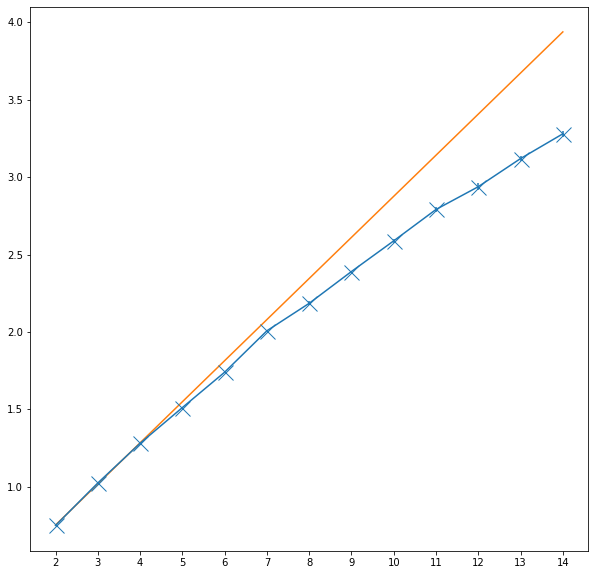

In [90]:
plt.figure(figsize=(10,10))
dat = [np.array([t.cpu().numpy() for t in mis[k][0]] )for k in mis ]
means = [np.mean(d) for d in dat]
sem = [scipy.stats.sem(d) for d in dat]
plt.errorbar(range(2,15), means, yerr = sem,   marker='x', markersize=15)
plt.xticks(range(2,15))
def f(x_arr, slope, intercept):
    return [slope * x + intercept for x in x_arr]
plt.plot(range(2,15), f(range(2, 15), slope, intercept))
plt.show()

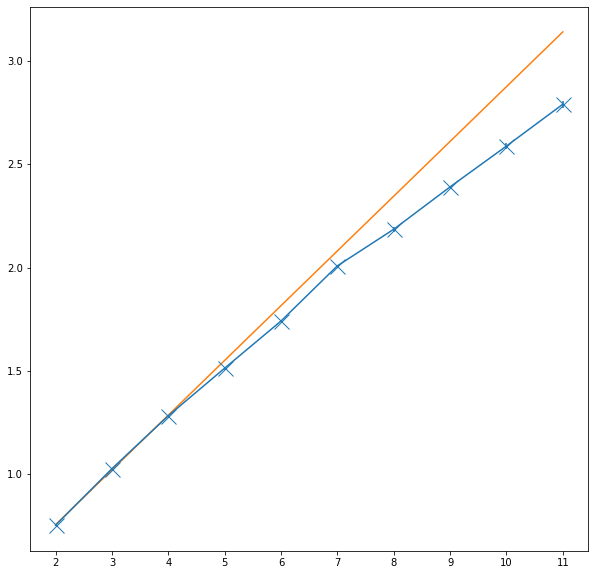

In [87]:
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(range(2, 5), means[:3])
plt.figure(figsize=(10,10))
plt.errorbar(range(2,12), means, yerr = sem,   marker='x', markersize=15)
plt.xticks(range(2,12))
def f(x_arr, slope, intercept):
    return [slope * x + intercept for x in x_arr]
plt.plot(range(2,12), f(range(2, 12), slope, intercept))
plt.show()

0.25391873717308044

(pid=109834) It 78 - MI: 0.4642720050178468 
(pid=109834) It 78 - Current MI: 2.5360288619995117 
(pid=109834) It 80 - Current MI: 2.5134127140045166 
(pid=109834) Final MI: 2.5173027515411377


# Analytic MI frozen convolution
<a id='IMXNuzYpbqF3yE71tcGPkyCUgonu44gg0wtJKI'></a>

In [ ]:
X = 1/8 * (np.array(Xlist).astype(float).sum(axis = (1, 2)) - np.array(Xlist)[:, 1, 1])
Y = 1/8 * (np.array(Ylist).astype(float).sum(axis = (1, 2)) - np.array(Ylist)[:, 1, 1])

In [ ]:
import matplotlib.pyplot as plt
plt.hist()

In [ ]:
X

In [ ]:
Y

In [ ]:
xy_pair = np.vstack([X, Y]).T
xy_pair

In [ ]:
from collections import defaultdict
joint_dict = defaultdict(int)
marginal_x = defaultdict(int)
marginal_y = defaultdict(int)
for pair in xy_pair:
    joint_dict[(tuple(pair))] += 1
    marginal_x[tuple(pair)[0]] += 1
    marginal_y[tuple(pair)[1]] += 1

In [ ]:
joint_dict

In [ ]:
marginal_x

In [ ]:
marginal_y

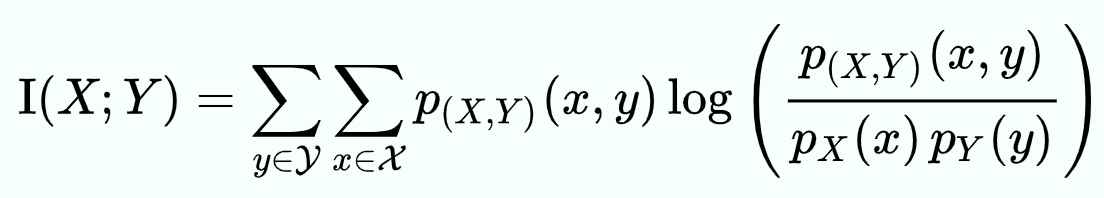

In [ ]:

def normalize_dict(dictionary):
    sum_ = 0
    for xy in dictionary:
        sum_ += dictionary[xy]
    for xy in dictionary:
        dictionary[xy] = dictionary[xy] / (sum_)
    return dictionary
joint_dict = normalize_dict(joint_dict)
marginal_x = normalize_dict(marginal_x)
marginal_y = normalize_dict(marginal_y)


In [ ]:
MI = 0
for xy in joint_dict:
    p_xy = joint_dict[xy]
    p_x = marginal_x[xy[0]]
    p_y = marginal_y[xy[1]]
    MI += p_xy * np.log (p_xy / (p_x * p_y))

In [ ]:
MI

## Analytic fine-grained MI calculation
<a id='W6fWYl5TZGWfK9Zt8dXCH65nSc5Uk'></a>

In [ ]:
X = np.array(Xlist).astype(float)#.reshape(-1, 9)
Y = np.array(Ylist).astype(float)#.reshape(-1, 9)

In [ ]:
X

In [ ]:
Xlist2x2 = []
Ylist2x2 = []
for _ in range(100000):
    num = np.random.randint(dat.shape[0])
    i = np.random.randint(dat.shape[1] - 3)
    j = np.random.randint(dat.shape[1] - 6)

    Xlist2x2.append(dat[num, i:(i+2), j:(j+2)])
    Ylist2x2.append(dat[num, i:(i+2), (j+2):(j+4)])

X = np.array(Xlist2x2).astype(float).reshape(-1, 4)
Y = np.array(Ylist2x2).astype(float).reshape(-1, 4)

In [ ]:
X

In [ ]:
Y

In [ ]:
xy_pair = np.hstack([X, Y])

In [ ]:
xy_pair[:3, :]

In [ ]:
joint_dict = defaultdict(int)
marginal_x = defaultdict(int)
marginal_y = defaultdict(int)
for pair in xy_pair:
    joint_dict[(tuple(pair))] += 1
    marginal_x[tuple(pair)[:4]] += 1
    marginal_y[tuple(pair)[4:]] += 1

In [ ]:
joint_dict

In [ ]:

def normalize_dict(dictionary):
    sum_ = 0
    for xy in dictionary:
        sum_ += dictionary[xy]
    for xy in dictionary:
        dictionary[xy] = dictionary[xy] / (sum_)
    return dictionary
joint_dict = normalize_dict(joint_dict)
marginal_x = normalize_dict(marginal_x)
marginal_y = normalize_dict(marginal_y)


In [ ]:
MI = 0
for xy in joint_dict:
    p_xy = joint_dict[xy]
    p_x = marginal_x[xy[:4]]
    p_y = marginal_y[xy[4:]]
    MI += p_xy * np.log (p_xy / (p_x * p_y))

In [ ]:
MI

In [ ]:
Ylist2x2

## Analytic MI frozen convolution
<a id='i4EUlSNUCLAqQFRTDCFVrpJ'></a>

In [ ]:
X = 1/4 * (np.array(Xlist2x2).astype(float).sum(axis = (1, 2))  )
Y = 1/4 * (np.array(Ylist2x2).astype(float).sum(axis = (1, 2))  )

In [ ]:
X

In [ ]:
Y

In [ ]:
xy_pair = np.vstack([X, Y]).T
xy_pair

In [ ]:
from collections import defaultdict
joint_dict = defaultdict(int)
marginal_x = defaultdict(int)
marginal_y = defaultdict(int)
for pair in xy_pair:
    joint_dict[(tuple(pair))] += 1
    marginal_x[tuple(pair)[0]] += 1
    marginal_y[tuple(pair)[1]] += 1

In [ ]:
joint_dict

In [ ]:
marginal_x

In [ ]:
marginal_y

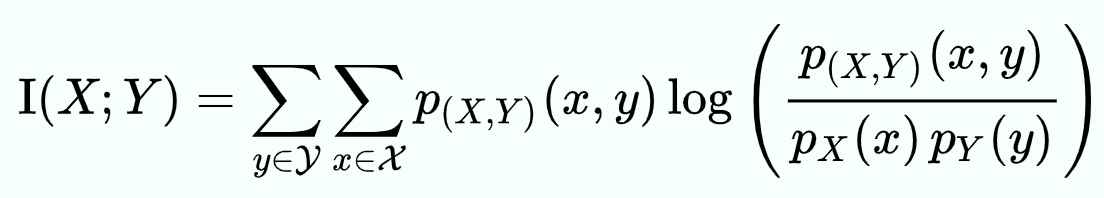

In [ ]:

def normalize_dict(dictionary):
    sum_ = 0
    for xy in dictionary:
        sum_ += dictionary[xy]
    for xy in dictionary:
        dictionary[xy] = dictionary[xy] / (sum_)
    return dictionary
joint_dict = normalize_dict(joint_dict)
marginal_x = normalize_dict(marginal_x)
marginal_y = normalize_dict(marginal_y)


In [ ]:
MI = 0
for xy in joint_dict:
    p_xy = joint_dict[xy]
    p_x = marginal_x[xy[0]]
    p_y = marginal_y[xy[1]]
    MI += p_xy * np.log (p_xy / (p_x * p_y))

In [ ]:
MI

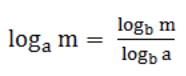

In [ ]:
log_2 x = log_e x / log_e 2
log_e (x() = log_2 (x) * log_e (2)


In [ ]:
Fine_grained MI = 0.62  / np.log(2)

In [ ]:
Fine_grained MI = 0.71

- Mine on the fine-grained data (on the 2x2 model)
- Mine on the frozen convolution coarse-graining (on the 2x2 model)
- Mine on the unfrozen convolution (and we optimize the convolution to get max info) (on the 2x2 model)
- Figure out if the log2 factor is confusing